# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 25 18:07:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 25%   31C    P8     1W / 250W |   2938MiB / 11018MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set up the environment


### Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = './'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [ ]:
#!gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [ ]:
#!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm # used for SNGAN


import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [ ]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),   # DCGAN input needs 64*64
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # show img will be effected by normalization 
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

In [ ]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

'''
images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
'''

'\nimages = [dataset[i] for i in range(16)]\ngrid_img = torchvision.utils.make_grid(images, nrow=4)\nplt.figure(figsize=(10,10))\nplt.imshow(grid_img.permute(1, 2, 0))\nplt.show()\n'

In [ ]:
images = [(dataset[i]+1)/2 for i in range(16)] # (dataset[i]+1)/2 = de-normalized
grid_img = torchvision.utils.make_grid(images, nrow=4)
'''
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
'''

'\nplt.figure(figsize=(10,10))\nplt.imshow(grid_img.permute(1, 2, 0))\nplt.show()\n'

## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,   # deconvolution : keeping the connectivity pattern of the convolution
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                #nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                spectral_norm(nn.Conv2d(in_dim, out_dim, 5, 2, 2)), # used for SNGAN
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
            
        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            #nn.Conv2d(in_dim, dim, 5, 2, 2), 
            spectral_norm(nn.Conv2d(in_dim, dim, 5, 2, 2)), # used for SNGAN
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            #nn.Conv2d(dim * 8, 1, 4),
            spectral_norm(nn.Conv2d(dim * 8, 1, 4)), # used for SNGAN
            nn.Sigmoid(), # not used in WGAN 
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1) # 1xn
        return y

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [ ]:
# Training hyperparameters
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch =  50# 50
n_critic = 1 # 5
#clip_value = 0.01  #used in WGAN

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

# Loss
criterion = nn.BCELoss() # binary cross entropy

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
#opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
#opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)


# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)


### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [ ]:
steps = 0
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # Compute the loss for the discriminator.
        # loss = original image and generated image result of descrimination, compute BCE loss /2 
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        #loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))
       

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        #for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs = G(z)

            # Model forwarding
            f_logit = D(f_imgs)
            
            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            #loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0 #de-nomalized
    filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    
    # Show generated images in the jupyter notebook.
    #grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    #plt.figure(figsize=(10,10))
    #plt.imshow(grid_img.permute(1, 2, 0))
    #plt.show()
    G.train()

    if (e+1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))



   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:03<00:00:00  9.05it/s  0.1485  4.5538    1    1115            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_001.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:05<00:00:00  8.92it/s  0.1859  3.3061    2    2230            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_002.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:06<00:00:00  8.85it/s  0.0522  3.2083    3    3345            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_003.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:07<00:00:00  8.74it/s  0.2168  3.9882    4    4460            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_004.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:06<00:00:00  8.79it/s  0.2768  1.5359    5    5575            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_005.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:04<00:00:00  8.93it/s  0.0818  1.5523    6    6690            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_006.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:07<00:00:00  8.77it/s  0.0846  4.5012    7    7805            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_007.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:06<00:00:00  8.79it/s  0.1689  3.4382    8    8920            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_008.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:07<00:00:00  8.73it/s  0.0981  4.2865    9    10035           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_009.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:08<00:00:00  8.69it/s  0.1716  5.0335   10    11150           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_010.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:07<00:00:00  8.72it/s  0.3748  2.3003   11    12265           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_011.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:06<00:00:00  8.80it/s  0.1383  2.9263   12    13380           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_012.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:08<00:00:00  8.70it/s  0.1354  1.3446   13    14495           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_013.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:06<00:00:00  8.85it/s  1.788   0.6467   14    15610           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_014.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:02:04<00:00:00  8.94it/s  0.1311  2.0682   15    16725           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_015.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:16<00:00:00  5.68it/s  0.1776  4.6478   16    17840           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_016.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0698  4.6905   17    18955           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_017.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.1508  2.1946   18    20070           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_018.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0185  5.1777   19    21185           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_019.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0233  4.4273   20    22300           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_020.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.87it/s  0.6795  5.3798   21    23415           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_021.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.1133  2.0558   22    24530           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_022.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.87it/s  0.2913  1.4094   23    25645           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_023.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.85it/s  0.4484  5.2844   24    26760           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_024.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.4078  3.4484   25    27875           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_025.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0251  5.7221   26    28990           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_026.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.87it/s  0.0715  2.2023   27    30105           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_027.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0639  3.121    28    31220           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_028.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.143   5.9965   29    32335           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_029.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.85it/s  0.0813  3.8105   30    33450           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_030.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.0949  3.8942   31    34565           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_031.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  1.7816  9.0175   32    35680           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_032.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0408  6.7304   33    36795           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_033.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.0084  4.7415   34    37910           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_034.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.1375  4.2861   35    39025           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_035.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.87it/s  0.2937  1.4523   36    40140           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_036.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0692  2.9113   37    41255           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_037.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0394  3.3136   38    42370           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_038.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0198  5.5571   39    43485           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_039.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.89it/s  0.0319  4.8233   40    44600           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_040.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.0032  6.1221   41    45715           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_041.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.85it/s  0.0019  7.5054   42    46830           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_042.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.86it/s  0.0295  5.1735   43    47945           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_043.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.0235  3.6598   44    49060           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_044.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.035   7.8097   45    50175           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_045.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.85it/s  0.0596  3.6989   46    51290           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_046.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.87it/s  0.0105  6.3855   47    52405           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_047.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0137  7.2022   48    53520           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_048.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G  Epoch  Step            
 1115/1115  00:03:49<00:00:00  4.87it/s  0.0545  3.5769   49    54635           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_049.jpg.


   Iters      Elapsed Time      Speed    Loss_D  Loss_G   Epoch  Step           
 1115/1115  00:03:48<00:00:00  4.88it/s  0.0046  10.1692   50    55750          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ./logs/Epoch_050.jpg.


## Inference
Use the trained model to generate anime faces!

### Load model 

In [ ]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.cuda()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


### Generate and show some images.


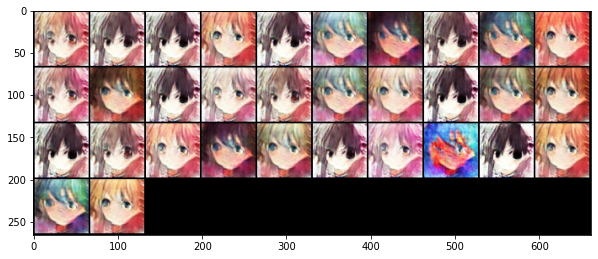

In [ ]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/home/siensien/hw6/output
/home/siensien/hw6
